## Project: Designing a Neural Network-Based Decision Support System for Optimal Crop Cultivation

Team Members:<br>
Suprit Shivshanthkumar Patil (G37575767)<br>
Omkar Balekundri (G41085894)<br>
Yash Manish Bobde (G20377188)<br>

In [ ]:
#Command to install packages from requirements.txt
%pip install -r requirements.txt 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, BatchNormalization, Conv1D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
data = pd.read_csv('./dataset.csv')  
le_period = LabelEncoder()
le_label = LabelEncoder()

In [3]:
column_names = data.columns
print(column_names)

Index(['Year', 'Period', 'price_cwt', 'N', 'P', 'K', 'temperature', 'humidity',
       'ph', 'rainfall', 'label'],
      dtype='object')


In [4]:
data.head()

,Year,Period,price_cwt,N,P,K,temperature,humidity,ph,rainfall,label
0,2014,JAN,21.5,40,72,77,17.0,17.0,7.5,88.6,Soyabeans
1,2014,JAN,21.5,23,72,84,19.0,17.1,6.9,79.9,Soyabeans
2,2014,JAN,21.5,39,58,85,17.9,15.4,6.0,68.5,Soyabeans
3,2014,JAN,21.5,22,72,85,18.9,15.7,6.4,88.5,Soyabeans
4,2014,JAN,21.5,36,67,77,18.4,19.6,7.2,79.3,Soyabeans


## Splitting data into traning, validation and test sets

Categorial lables are encoded using LabelEncoder. The dataset is split into features (X) and labels (y). Train-test split is performed twice to create training, validation, and testing sets. The input features are reshaped to suit the RNN model format.

In [5]:
le_label.fit(data['label'])

data['Period'] = le_period.fit_transform(data['Period'])
data['label'] = le_label.transform(data['label'])

X = data[['Year', 'Period', 'price_cwt', 'N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']]
y = data['label']

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train_raw, X_val_raw, y_train, y_val = train_test_split(X_train_raw, y_train, test_size=0.2, random_state=42, stratify=y_train)

X_train = X_train_raw[['Year', 'Period', 'N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']]
X_test = X_test_raw[['Year', 'Period', 'N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']]
X_val = X_val_raw[['Year', 'Period', 'N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']]

X_train = np.reshape(X_train.values, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val.values, (X_val.shape[0], X_val.shape[1], 1))
X_test = np.reshape(X_test.values, (X_test.shape[0], X_test.shape[1], 1))

y_train_cwt = X_train_raw['price_cwt']
y_test_cwt = X_test_raw['price_cwt']
y_val_cwt = X_val_raw['price_cwt']

## Preparing data for RNN

Padding is used for input sequences with zeros to ensure uniform length and creates TensorFlow datasets for training, testing, and validation.  

In [6]:
sequence_length = 12

X_train_padded = np.pad(X_train, ((0, sequence_length), (0, 0), (0, 0)), mode='constant', constant_values=0)
X_test_padded = np.pad(X_test, ((0, sequence_length), (0, 0), (0, 0)), mode='constant', constant_values=0)
X_val_padded = np.pad(X_val, ((0, sequence_length), (0, 0), (0, 0)), mode='constant', constant_values=0)

train_dataset_rnn = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=X_train_padded,
    targets=y_train_cwt,
    sequence_length=sequence_length,
    batch_size=16,
    shuffle=True
)

test_dataset_rnn = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=X_test_padded,
    targets=y_test_cwt,
    sequence_length=sequence_length,
    batch_size=16,
    shuffle=True
)

val_dataset_rnn = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=X_val_padded,
    targets=y_val_cwt,
    sequence_length=sequence_length,
    batch_size=16,
    shuffle=True
)

In [7]:
X_train.shape

(29029, 9, 1)

In [8]:
for x, y in train_dataset_rnn.take(1):
    print("Shape of features (X) in train_dataset:", x.shape)
    print("Shape of labels (Y) in train_dataset:", y.shape)

for x, y in test_dataset_rnn.take(1):
    print("Shape of features (X) in test_dataset:", x.shape)
    print("Shape of labels (Y) in test_dataset:", y.shape)

Shape of features (X) in train_dataset: (16, 12, 9, 1)
Shape of labels (Y) in train_dataset: (16,)
Shape of features (X) in test_dataset: (16, 12, 9, 1)
Shape of labels (Y) in test_dataset: (16,)


## RNN model

In [9]:
rnn_input = Input(shape=(sequence_length, X_train.shape[1]), name='rnn_input')  
x1 = LSTM(80, return_sequences=True)(rnn_input)
x1 = Dropout(0.2)(x1)
x1 = LSTM(80)(x1)
value_per_cwt_pred = Dense(1, activation='linear', name='value_per_cwt_pred')(x1)


In [10]:
lr_rnn = 0.00001
opt_rnn = Adam(learning_rate=lr_rnn)
rnn_model = Model(rnn_input, value_per_cwt_pred)
rnn_model.compile(optimizer=opt_rnn, loss='mse', metrics=['mse'])  

early_stopping = EarlyStopping(monitor='val_loss', patience=3)
rnn_history = rnn_model.fit(
    train_dataset_rnn,
    validation_data=val_dataset_rnn,
    epochs=15,
    callbacks=[early_stopping]
)

Epoch 1/15
1815/1815 [==============================] - 11s 5ms/step - loss: 101.8931 - mse: 101.8931 - val_loss: 57.9815 - val_mse: 57.9815
Epoch 2/15
1815/1815 [==============================] - 11s 6ms/step - loss: 53.7776 - mse: 53.7776 - val_loss: 51.1295 - val_mse: 51.1295
Epoch 3/15
1815/1815 [==============================] - 12s 6ms/step - loss: 51.8958 - mse: 51.8958 - val_loss: 51.0081 - val_mse: 51.0081
Epoch 4/15
1815/1815 [==============================] - 10s 6ms/step - loss: 51.7726 - mse: 51.7726 - val_loss: 50.3481 - val_mse: 50.3481
Epoch 5/15
1815/1815 [==============================] - 10s 6ms/step - loss: 44.7833 - mse: 44.7833 - val_loss: 31.3657 - val_mse: 31.3657
Epoch 6/15
1815/1815 [==============================] - 10s 5ms/step - loss: 33.1580 - mse: 33.1580 - val_loss: 23.2706 - val_mse: 23.2706
Epoch 7/15
1815/1815 [==============================] - 10s 5ms/step - loss: 27.9714 - mse: 27.9714 - val_loss: 19.7995 - val_mse: 19.7995
Epoch 8/15
1815/1815 [===

## Plotting the training loss and accuracy of the RNN model

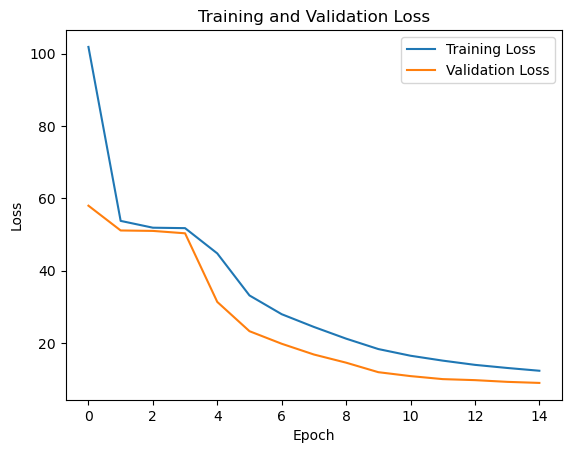

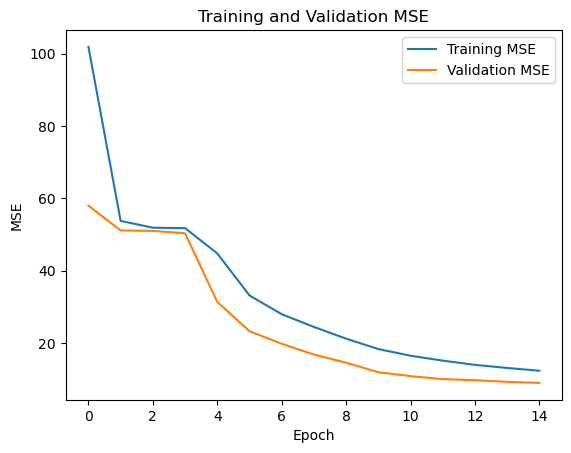

In [11]:
plt.plot(rnn_history.history['loss'], label='Training Loss')
plt.plot(rnn_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

train_mse = rnn_history.history['mse']
val_mse = rnn_history.history['val_mse']

plt.plot(train_mse, label='Training MSE')
plt.plot(val_mse, label='Validation MSE')
plt.title('Training and Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [12]:
test_loss, mse = rnn_model.evaluate(test_dataset_rnn)
print("\nTest Loss:", test_loss)
print("Test mse:", mse)

567/567 [==============================] - 1s 2ms/step - loss: 9.3951 - mse: 9.3951

Test Loss: 9.395096778869629
Test mse: 9.395096778869629


## Shaping data and combining for CNN input

Predictions using the trained RNN model, then the dimensions of the predictions is expanded. Further the expanded predictions is merged with the training, validation and test datasets for the CNN input.

In [13]:
#Predicted values of price/CWT from trained RNN model that will used for CNN input.
predicted_cwt_train = rnn_model.predict(train_dataset_rnn)
predicted_cwt_val = rnn_model.predict(val_dataset_rnn)
predicted_cwt_test = rnn_model.predict(test_dataset_rnn)

print("Shape of predicted_cwt_train:", predicted_cwt_train.shape)
print("Shape of predicted_cwt_val:", predicted_cwt_val.shape)
print("Shape of predicted_cwt_test:", predicted_cwt_test.shape)

#Predicted values are expanded to match with the shape of X_train, X_val and X_test.
predicted_cwt_train_expanded = np.expand_dims(predicted_cwt_train, axis=1)
predicted_cwt_val_expanded = np.expand_dims(predicted_cwt_val, axis=1)
predicted_cwt_test_expanded = np.expand_dims(predicted_cwt_test, axis=1)

print("\nShape of X_train:", X_train.shape)
print("Shape of predicted_cwt_train_expanded:", predicted_cwt_train_expanded.shape)

print("\nShape of X_test:", X_train.shape)
print("Shape of predicted_cwt_test_expanded:", predicted_cwt_test_expanded.shape)

#The expanded predcited values is mergerd with X_train, X_val and X_test. 
X_train_augmented = np.concatenate([X_train, predicted_cwt_train_expanded], axis=1)
X_val_augmented = np.concatenate([X_val, predicted_cwt_val_expanded], axis=1)
X_test_augmented = np.concatenate([X_test, predicted_cwt_test_expanded], axis=1)

print("\nShape of X_train_augmented:", X_train_augmented.shape)
print("Shape of X_val_augmented:", X_val_augmented.shape)
print("Shape of X_test_augmented:", X_test_augmented.shape)



567/567 [==============================] - 1s 2ms/step
Shape of predicted_cwt_train: (29029, 1)
Shape of predicted_cwt_val: (7258, 1)
Shape of predicted_cwt_test: (9072, 1)

Shape of X_train: (29029, 9, 1)
Shape of predicted_cwt_train_expanded: (29029, 1, 1)

Shape of X_test: (29029, 9, 1)
Shape of predicted_cwt_test_expanded: (9072, 1, 1)

Shape of X_train_augmented: (29029, 10, 1)
Shape of X_val_augmented: (7258, 10, 1)
Shape of X_test_augmented: (9072, 10, 1)


In [14]:
X_train_augmented.shape[0]

29029

## CNN model

The augmented values are then used as input values for the training of CNN model.

In [15]:
cnn_input = Input(shape=(X_train_augmented.shape[1], X_train_augmented.shape[2]), name='cnn_input')
x = Conv1D(16,3,activation='relu')(cnn_input)
x = BatchNormalization()(x)  
x = Dropout(0.3)(x)

x = Conv1D(32,3,activation='relu')(cnn_input)
x = BatchNormalization()(x)  
x = Dropout(0.5)(x)
x = Flatten()(x)

x = Dense(32, activation='relu')(x)

crop_prediction = Dense(len(np.unique(y_train)), activation='softmax', name='crop_prediction')(x)


In [16]:
lr_cnn = 0.00001
cnn_model = Model(cnn_input, crop_prediction)
opt_cnn = Adam(learning_rate=lr_cnn)
cnn_model.compile(optimizer=opt_cnn, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_history = cnn_model.fit(
    X_train_augmented, y_train,
    validation_data=(X_val_augmented, y_val),  
    epochs=15, batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/15
908/908 [==============================] - 1s 834us/step - loss: 1.8776 - accuracy: 0.2724 - val_loss: 1.2859 - val_accuracy: 0.4284
Epoch 2/15
908/908 [==============================] - 1s 783us/step - loss: 1.2478 - accuracy: 0.4465 - val_loss: 0.8095 - val_accuracy: 0.8993
Epoch 3/15
908/908 [==============================] - 1s 698us/step - loss: 0.7935 - accuracy: 0.7232 - val_loss: 0.4265 - val_accuracy: 0.9990
Epoch 4/15
908/908 [==============================] - 1s 633us/step - loss: 0.4833 - accuracy: 0.8875 - val_loss: 0.1945 - val_accuracy: 1.0000
Epoch 5/15
908/908 [==============================] - 1s 740us/step - loss: 0.2912 - accuracy: 0.9509 - val_loss: 0.0935 - val_accuracy: 1.0000
Epoch 6/15
908/908 [==============================] - 1s 637us/step - loss: 0.1832 - accuracy: 0.9767 - val_loss: 0.0509 - val_accuracy: 1.0000
Epoch 7/15
908/908 [==============================] - 1s 636us/step - loss: 0.1173 - accuracy: 0.9867 - val_loss: 0.0296 - val_accuracy:

## Plotting the training loss and accuracy of the CNN model

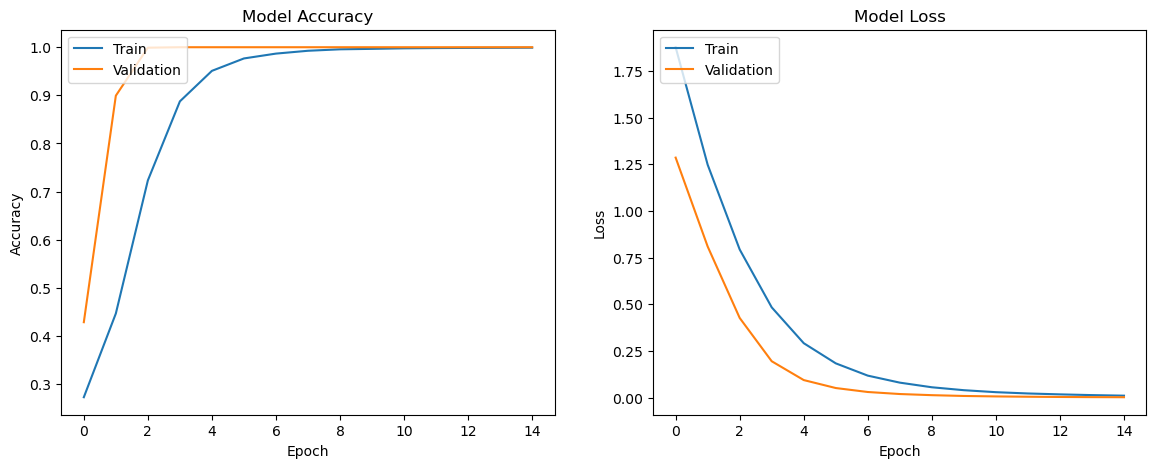

In [17]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [18]:
test_loss_cnn, test_accuracy_cnn = cnn_model.evaluate(X_test_augmented, y_test)
print("\nTest Loss:", test_loss_cnn)
print("Test Accuracy:", test_accuracy_cnn)

284/284 [==============================] - 0s 402us/step - loss: 0.0016 - accuracy: 1.0000

Test Loss: 0.001612223801203072
Test Accuracy: 1.0


## Single value Prediction

The function predicts crop prices and classifies crops based on single sample data using trained RNN and CNN models. Similar to the data processing done during the training, here data is padded and sequences are created for RNN input. Further, the predictions are expanded and combined with the features of sample data for the CNN input.

In [19]:
def pred_crop_price(sample_data, rnn_model, cnn_model, le_period, le_label, sequence_length=12):
    
    sample_df = pd.DataFrame([sample_data])
    sample_df['Period'] = le_period.transform(sample_df['Period'])
    
    sample_padded = np.pad(sample_df.values, ((0, sequence_length - 1), (0, 0)), mode='constant', constant_values=0)
    sample_sequence = np.reshape(sample_padded, (1, sequence_length, sample_df.shape[1]))
    
    rnn_prediction = rnn_model.predict(sample_sequence)
    
    rnn_pred_exp = np.expand_dims(rnn_prediction, axis=1)
    sample_df_reshape = np.reshape(sample_df.values, (sample_df.shape[0], sample_df.shape[1], 1))
    
    cnn_ip_aug = np.concatenate([sample_df_reshape, rnn_pred_exp], axis=1)
    cnn_prediction = cnn_model.predict(cnn_ip_aug)
    
    predicted_class = le_label.inverse_transform([np.argmax(cnn_prediction)])
    predicted_price = rnn_prediction.flatten()[0]
    
    return predicted_price, predicted_class

## Sample predition of original values 
Actual crop: Rice<br>
Actual Price/CWT: 19.6

In [23]:
sample_data = {
    'Year': 2024,
    'Period': 'JAN',
    'N': 73,
    'P': 57,
    'K': 41,
    'temperature': 21.4,
    'humidity': 84.9,
    'ph': 5.8,
    'rainfall': 272.2,
}

predicted_price, predicted_class = pred_crop_price(sample_data, rnn_model, cnn_model, le_period, le_label)

print("\nPredicted Price per CWT:", predicted_price)
print("Predicted Class:", predicted_class)

1/1 [==============================] - 0s 15ms/step

Predicted Price per CWT: 13.806007
Predicted Class: ['rice']


## Sample predition of original values 
Actual crop: Maize<br>
Actual Price/CWT: 8.5

In [21]:
sample_data = {
    'Year': 2024,
    'Period': 'JAN',
    'N': 71,
    'P': 54,
    'K': 16,
    'temperature': 22.6,
    'humidity': 63.7,
    'ph': 5.7,
    'rainfall': 87.8,
}

predicted_price, predicted_class = pred_crop_price(sample_data, rnn_model, cnn_model, le_period, le_label)

print("\nPredicted Price per CWT:", predicted_price)
print("Predicted Class:", predicted_class)

1/1 [==============================] - 0s 8ms/step

Predicted Price per CWT: 6.3022537
Predicted Class: ['maize']


## Sample predition of original values 
Actual crop: Soyabeans<br>
Actual Price/CWT: 21.3

In [22]:
sample_data = {
    'Year': 2024,
    'Period': 'JAN',
    'N': 40,
    'P': 72,
    'K': 77,
    'temperature': 17,
    'humidity': 17,
    'ph': 7.5,
    'rainfall': 88.6,
}

predicted_price, predicted_class = pred_crop_price(sample_data, rnn_model, cnn_model, le_period, le_label)

print("\nPredicted Price per CWT:", predicted_price)
print("Predicted Class:", predicted_class)

1/1 [==============================] - 0s 8ms/step

Predicted Price per CWT: 15.498697
Predicted Class: ['Soyabeans']
